In [1]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\sbp_toy_abm")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from calibrated_abm.model import FLCalibratedABM

%matplotlib inline

# Model initialization, step and collection of outputs

Import data on farmers and farms

In [3]:
farmers_data = ".\data\FarmersData.xlsx"
farms_data = ".\data\FarmsData.xlsx"

Provide payments for SBP adoption

In [4]:
# Give payments in €/hectare, one entry for each year 
sbp_payments = [50.72, 50.72, 51.82]
payments = {"Sown Permanent Pasture": sbp_payments}

Provide costs for pastures

In [5]:
pastures_costs = {"Sown Permanent Pasture": {
                    "installation": [-722.97],
                    "maintenance": [0.00, -135.96, 0.00, -318.27, 0.00,
                                    -135.96, 0.00, -318.27, 0.00]
                          },
                  'Natural Pasture': {
                      "installation": [0.],
                      "maintenance": [-235.40, -210.18, -210.18, -210.18,
                                      -210.18, -235.40, -210.18, -210.18, 
                                      -210.18]
                      }
                  }

Provide weights of the best model found

In [6]:
weights = (1.25, 0.75, -0.5, 0.25)

Initialize and run one step

In [7]:
# Note that the model is initialized with a seed to have the same results
model = FLCalibratedABM(weights, payments, pastures_costs)

In [8]:
model.step()

Retrieve adoption at the farmer level

In [9]:
adoption_output = model.datacollector.get_agent_vars_dataframe()

In [17]:
final_adoption = adoption_output.loc[max(adoption_output.index.get_level_values(0).tolist())]
final_adoption = final_adoption.set_index('FARM_ID')
final_adoption.head()

,Pasture,Confidence factor,Differential ENPV SBP
FARM_ID,,,
PT02,Natural Pasture,0.436583,-212.515505
PT13,Sown Permanent Pasture,0.990655,249.982460
PT15,Sown Permanent Pasture,1.155911,387.926273
PT16,Natural Pasture,0.583333,-90.019350
PT17,Sown Permanent Pasture,1.152066,384.716436


Retrieve adoption at the aggregated level

In [11]:
aggregate_adoption = model.datacollector.get_model_vars_dataframe()
aggregate_adoption

,Percentage of adoption
0,76.666667


# Results analysis

<AxesSubplot:>

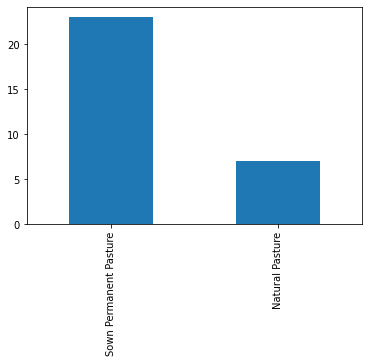

In [12]:
pd.value_counts(final_adoption['Pasture']).plot.bar()

In [13]:
final_adoption['Confidence factor'].describe()

count    30.000000
mean      1.034443
std       0.497939
min      -0.202463
25%       0.716492
50%       0.969523
75%       1.360368
max       1.979942
Name: Confidence factor, dtype: float64

<AxesSubplot:>

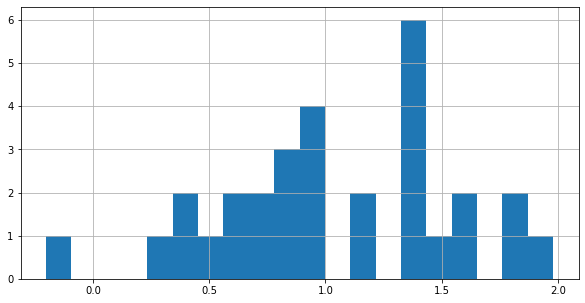

In [14]:
final_adoption['Confidence factor'].hist(bins=20, figsize=(10, 5))

<AxesSubplot:>

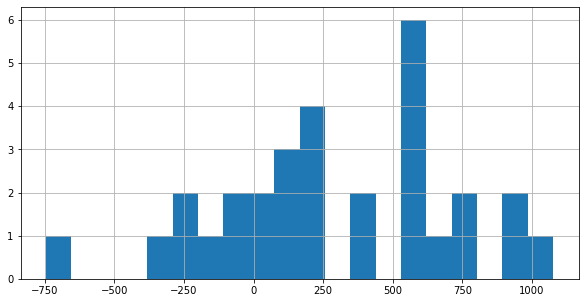

In [15]:
final_adoption['Differential ENPV SBP'].hist(bins=20, figsize=(10, 5))

# Model validation

Get real adoption data

In [100]:
real_adoption_path = ".\data\FarmsDataValidation.xlsx"
real_adoption = pd.read_excel(real_adoption_path, index_col=0)
real_adoption.head()

,Pasture
FARM_ID,
PT02,Natural Pasture
PT13,Sown Permanent Pasture
PT15,Sown Permanent Pasture
PT16,Natural Pasture
PT17,Sown Permanent Pasture


<AxesSubplot:>

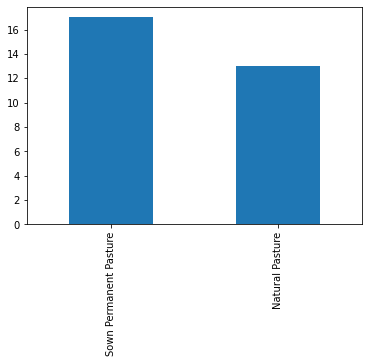

In [101]:
pd.value_counts(real_adoption['Pasture']).plot.bar()

## Micro-level validation

In [102]:
import sklearn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [103]:
pred_adoption = final_adoption['Pasture']

In [104]:
# Ordered in the right way: the first, Natural Pature, is considered the negative class
confusion_matrix(real_adoption, pred_adoption)

array([[ 6,  7],
       [ 1, 16]], dtype=int64)

In [105]:
print('Precision:', precision_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture'))
print('Recall:', recall_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture'))
print('F1 score:', f1_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture'))

Precision: 0.6956521739130435
Recall: 0.9411764705882353
F1 score: 0.7999999999999999


## Macro-level validation

In [106]:
real_farmers_adopted = real_adoption['Pasture'].value_counts()['Sown Permanent Pasture']
real_percentage_adoption = real_farmers_adopted / len(real_adoption['Pasture'])*100
print(real_farmers_adopted, real_percentage_adoption)

17 56.666666666666664


In [107]:
modelled_percentage_adoption = aggregate_adoption.iloc[0, 0]
num_adopters = sum(pas == "Sown Permanent Pasture" for pas in final_adoption['Pasture'])
print(num_adopters, modelled_percentage_adoption)

23 76.66666666666667
